In [1]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler

In [43]:
def load_arff(path):
    print(f'loading {path}\n')
    data, meta = loadarff(path)
    class_name = meta.names()[-1]
    df_data = pd.DataFrame(data)
    classes = {c:i for i,c in enumerate(df_data[class_name].unique())}
    print('mapping classes', classes)
    df_data[class_name] = df_data[class_name].map(classes)
    print(df_data[class_name].value_counts())
    print()
    df_data.info()
    return df_data

def load_mat(path):
    print(f'loading {path}\n')
    mat = loadmat(path)
    if (path == 'data/prostate_GE.mat'):
        mat["Y"] = mat["Y"] - 1
    df_data = pd.DataFrame(np.hstack((mat["X"], mat["Y"])))
    return df_data

In [68]:
import matlab.engine
def Afshar2020_filter(n_genes, data, label):
    #print('running', 'Afshar2020_filter', n_genes)
    mat_a = matlab.double(np.append(data, label.reshape(-1, 1), axis=1).tolist())
    eng = matlab.engine.start_matlab()
    eng.addpath('./Afshar2020_filter')
    #print(mat_a.size)
    res = eng.Afshar2020_filter(mat_a, n_genes)
    #print(res)
    selected = np.asarray(res, dtype=np.int32)[0][:n_genes]
    #print(selected)
    return data[:, selected]

In [4]:
# OUT version, FS outside of CV loop (original)
import numpy as np
from sklearn import model_selection,svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def VSSRFE(n_genes, data, label):
    X=data
    y=label
    m, n_features = X.shape
    clf = svm.LinearSVC(penalty='l1',loss='squared_hinge',C=0.7,dual=False,fit_intercept=True,random_state=1, max_iter=5000)
    count = n_features
    cut=n_features
    n_steps=400
    X_tmp=X
    while count > n_genes:
        count = count - n_steps
        if cut / count>=2 and n_steps>1:
            cut=count
            n_steps=n_steps//2
        clf.fit(X_tmp, y)
        coef=[abs(e) for e in (clf.coef_)[0]]
        coef_sorted=np.argsort(coef)[::-1]
        coef_eliminated=coef_sorted[:count]
        X_tmp = X_tmp[:, coef_eliminated]
    return X_tmp

In [5]:
from sklearn.tree import DecisionTreeClassifier

import sys
sys.path.append("konsensus")
from model.model import *

def ensemble(n_genes, data, label):
    m = Model([LogisticRegressionCV(penalty='l2', solver='newton-cg', multi_class='multinomial'),
           LogisticRegressionCV(penalty='l1', solver='liblinear'),
           DecisionTreeClassifier()])
    m.fit(data, label)
    selected = np.argsort(-m.perform_voting())[:n_genes]
    return data[:, selected]

def lr_l1(n_genes, data, label):
    m = Model([LogisticRegressionCV(penalty='l1', solver='liblinear')])
    m.fit(data, label)
    selected = np.argsort(-m.perform_voting())[:n_genes]
    return data[:, selected]

def lr_l2(n_genes, data, label):
    m = Model([LogisticRegressionCV(penalty='l2', solver='newton-cg')])
    m.fit(data, label)
    selected = np.argsort(-m.perform_voting())[:n_genes]
    return data[:, selected]

In [6]:
import time

def test_model(model, n_genes, data, label, clf):
    idx = np.random.permutation(len(data))
    data,label = data[idx], label[idx]
    
    start = time.time()
    data=model(n_genes, data, label)
    end = time.time()
    fs_time = end - start
    
    ls_acc=[];ls_mcc=[];ls_auc=[];ls_sen=[];ls_spe=[];ls_f1=[]
    skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True)
    #clf = svm.SVC(kernel='linear',C=1.0,probability=True)
    for train_index, test_index in skf.split(data,label):
        clf.fit(data[train_index], label[train_index])
        acc=clf.score(data[test_index],label[test_index])
        ls_acc.append(acc)
        y_pred = clf.predict(data[test_index])
        y_true = label[test_index]
        mcc=metrics.matthews_corrcoef(y_true,y_pred)
        ls_mcc.append(mcc)
        fpr, tpr, thresholds = metrics.roc_curve(y_true, (clf.predict_proba(data[test_index]))[:,1])
        auc=metrics.auc(fpr,tpr)
        ls_auc.append(auc)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        ls_spe.append(tn / (tn+fp))
        ls_sen.append(tp / (tp+fn))
        ls_f1.append(metrics.f1_score(y_true, y_pred))
        
    #print('ls_acc', ls_acc)
    #print('ls_auc', ls_auc)
    #print('ls_mcc', ls_mcc)
    #print('ls_sen', ls_sen)
    #print('ls_spe', ls_spe)
    #print('ls_f1', ls_f1)
    return np.mean(ls_acc), np.mean(ls_auc), np.mean(ls_mcc), np.mean(ls_sen), np.mean(ls_spe), np.mean(ls_f1), fs_time

In [44]:
datasets = [
    ('CNS', load_arff('data/CNS.arff')),
    ('Breast', load_arff('data/Breast.arff')),
    ('Ovarian', load_arff('data/Ovarian.arff')),
    ('Leukemia', load_arff('data/Leukemia.arff')),
    ('Prostate', load_mat('data/prostate_GE.mat')),
    ('Colon', load_mat('data/colon.mat'))
]

loading data/CNS.arff

mapping classes {b'1': 0, b'0': 1}
1    39
0    21
Name: CLASS, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 7130 entries, AFFX-BioB-5_at to CLASS
dtypes: float64(7129), int64(1)
memory usage: 3.3 MB
loading data/Breast.arff

mapping classes {b'relapse': 0, b'non-relapse': 1}
1    51
0    46
Name: Class, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Columns: 24482 entries, Contig45645_RC to Class
dtypes: float64(24481), int64(1)
memory usage: 18.1 MB
loading data/Ovarian.arff

mapping classes {b'Normal': 0, b'Cancer': 1}
1    162
0     91
Name: Class, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Columns: 15155 entries, MZ-7.86E-05 to Class
dtypes: float64(15154), int64(1)
memory usage: 29.3 MB
loading data/Leukemia.arff

mapping classes {b'ALL': 0, b'AML': 1}
0    47
1    25
Name: CLASS, dtype: int64

<class 'pandas.core.frame.DataFrame'>

In [55]:
def test_dataset(dataset, n_runs, clf):
    results = {}
    print('processing ', dataset[0])
    scaler = StandardScaler()
    x_raw = dataset[1].iloc[:, :-1]
    x = scaler.fit_transform(x_raw)
    y = dataset[1].iloc[:, -1].to_numpy()
    
    ticks = [i for i in range(5,21,5)] + [i for i in range(30,51,10)]
    models = [#('VSSRFE', VSSRFE), 
              ('DRPT', Afshar2020_filter),
              #('lr_l1', lr_l1),
              #('lr_l2', lr_l2),
              ('ensemble', ensemble)]
    
    
    for (m_name, m) in models:
        print('start', m_name)
        for n in ticks:
            acc=[]
            auc=[]
            mcc=[]
            sen=[]
            spe=[]
            f1=[]
            time=[]
            for i in range(n_runs):
                ac,au,mc,se,sp,f,t=test_model(m, n, x, y, clf)
                acc.append(ac)
                auc.append(au)
                mcc.append(mc)
                sen.append(se)
                spe.append(sp)
                f1.append(f)
                time.append(t)
                print('end run', i)
            print(m_name, 'end n_features =', n)
            results[m_name] = results.get(m_name, []) + [(n, np.mean(acc), np.mean(auc), np.mean(mcc), np.mean(sen), np.mean(spe),np.mean(f1),np.mean(time))]
    return results

In [9]:
import matplotlib.pyplot as plt

def plot_results(dataset_name, classifier_name, results):
    fig = plt.figure(figsize=(12, 14), dpi=80)
    fig.suptitle(dataset_name + ' - ' + classifier_name, fontsize=28)  
    
    plt.subplot(3, 2, 1)
    for (name, res) in results.items():
        plt.plot([i[0] for i in res],[i[1] for i in res], 'o-', label=name)
    plt.xticks([i[0] for i in res]);
    plt.grid(True)
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(3, 2, 2)
    for (name, res) in results.items():
        plt.plot([i[0] for i in res],[i[6] for i in res], 'o-', label=name)
    plt.xticks([i[0] for i in res]);
    plt.grid(True)
    plt.title('F1')
    plt.legend()

    plt.subplot(3, 2, 3)
    for (name, res) in results.items():
        plt.plot([i[0] for i in res],[i[4] for i in res], 'o-', label=name)
    plt.xticks([i[0] for i in res]);
    plt.grid(True)
    plt.title('Sensitivity')
    plt.legend()

    plt.subplot(3, 2, 4)
    for (name, res) in results.items():
        plt.plot([i[0] for i in res],[i[5] for i in res], 'o-', label=name)
    plt.xticks([i[0] for i in res]);
    plt.grid(True)
    plt.title('Specificity')
    plt.legend()

    plt.subplot(3, 2, 5)
    for (name, res) in results.items():
        plt.plot([i[0] for i in res],[i[2] for i in res], 'o-', label=name)
    plt.xticks([i[0] for i in res]);
    plt.grid(True)
    plt.title('AUC')
    plt.legend()

    plt.subplot(3, 2, 6)
    for (name, res) in results.items():
        plt.plot([i[0] for i in res],[i[3] for i in res], 'o-', label=name)
    plt.xticks([i[0] for i in res]);
    plt.grid(True)
    plt.title('MCC')
    plt.legend()

    plt.show()

In [17]:
svc07 = svm.SVC(kernel='linear',C=0.7,probability=True)
results_cns_svc07_10 = test_dataset(datasets[0], 10, svc07)

processing  CNS
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5

/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0
end run 1
end run 2
end run 3
end run 4
end run 5


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 50
start lr_l2


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0
end run 1
end run 2


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 50
start ensemble


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


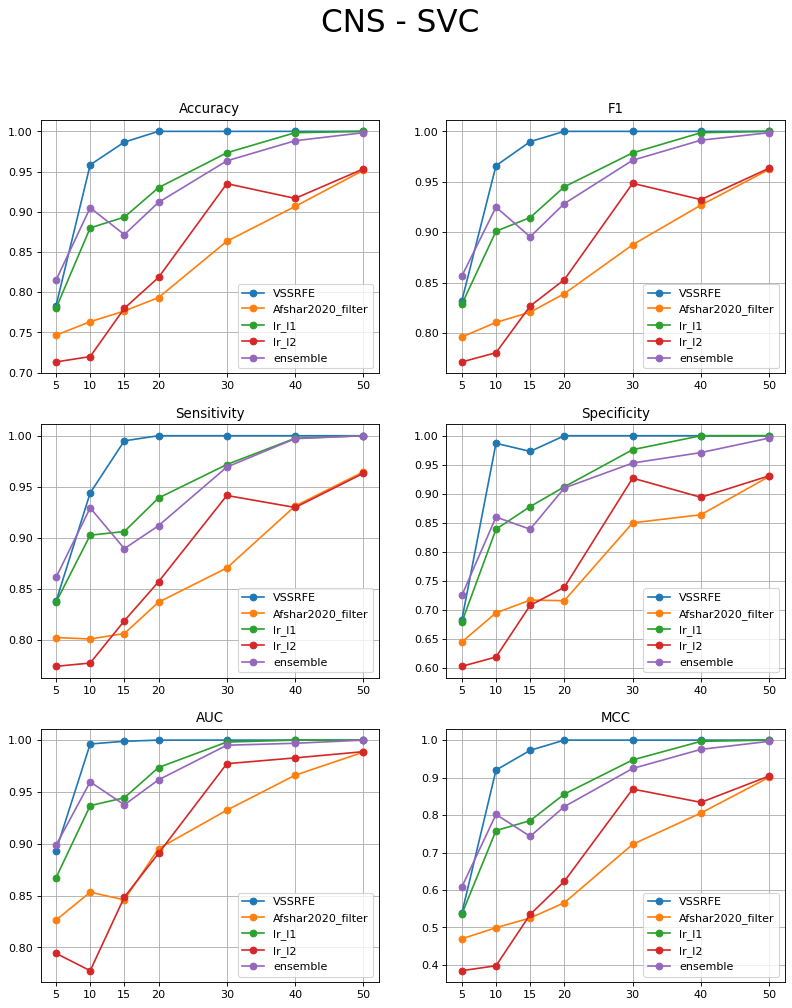

In [18]:
plot_results(datasets[0][0], 'SVC', results_cns_svc07_10)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn4 = KNeighborsClassifier(n_neighbors=4)
results_cns_knn4_10 = test_dataset(datasets[0], 10, knn4)

processing  CNS
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


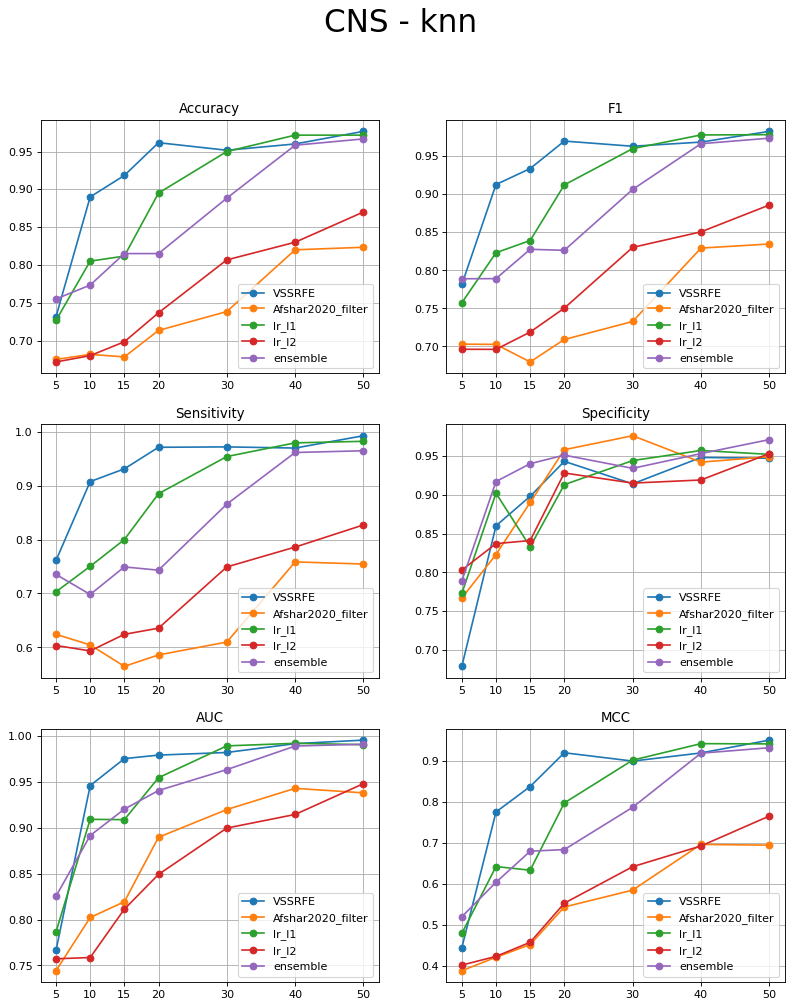

In [22]:
plot_results(datasets[0][0], 'knn', results_cns_knn4_10)

In [23]:
svc07 = svm.SVC(kernel='linear',C=0.7,probability=True)
results_breast_svc07_10 = test_dataset(datasets[1], 10, svc07)

processing  Breast
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end ru

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 50


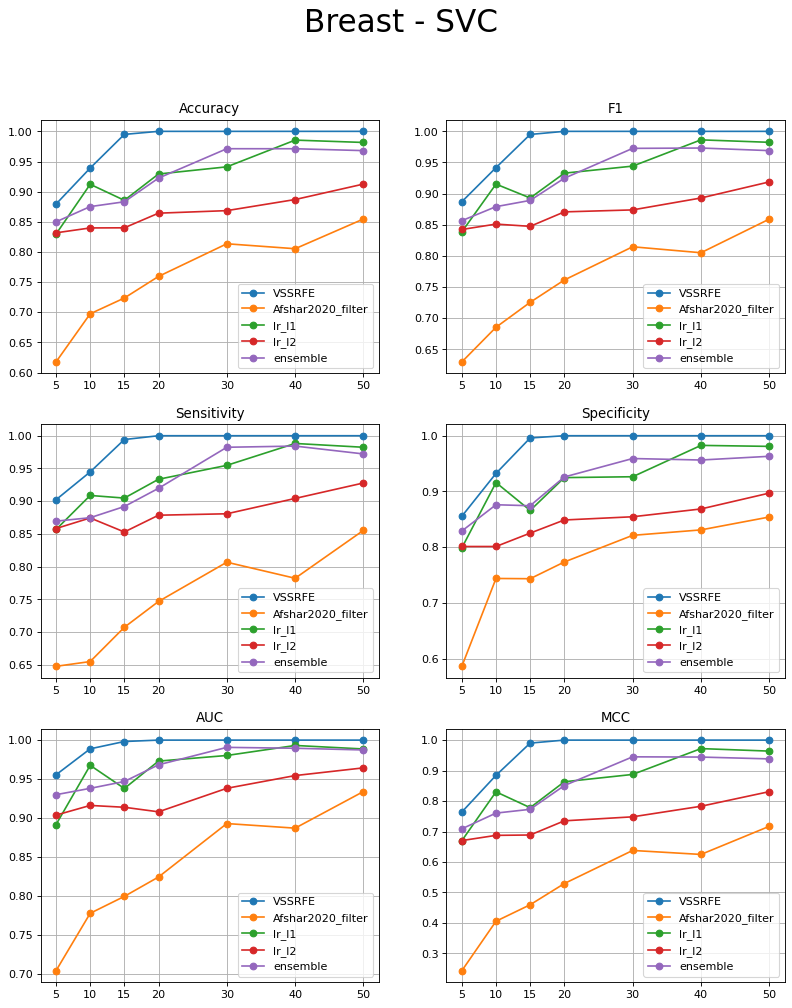

In [25]:
plot_results(datasets[1][0], 'SVC', results_breast_svc07_10)

In [26]:
knn4 = KNeighborsClassifier(n_neighbors=4)
results_breast_knn4_10 = test_dataset(datasets[1], 10, knn4)

processing  Breast
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end ru

/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 50
start lr_l1
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 50


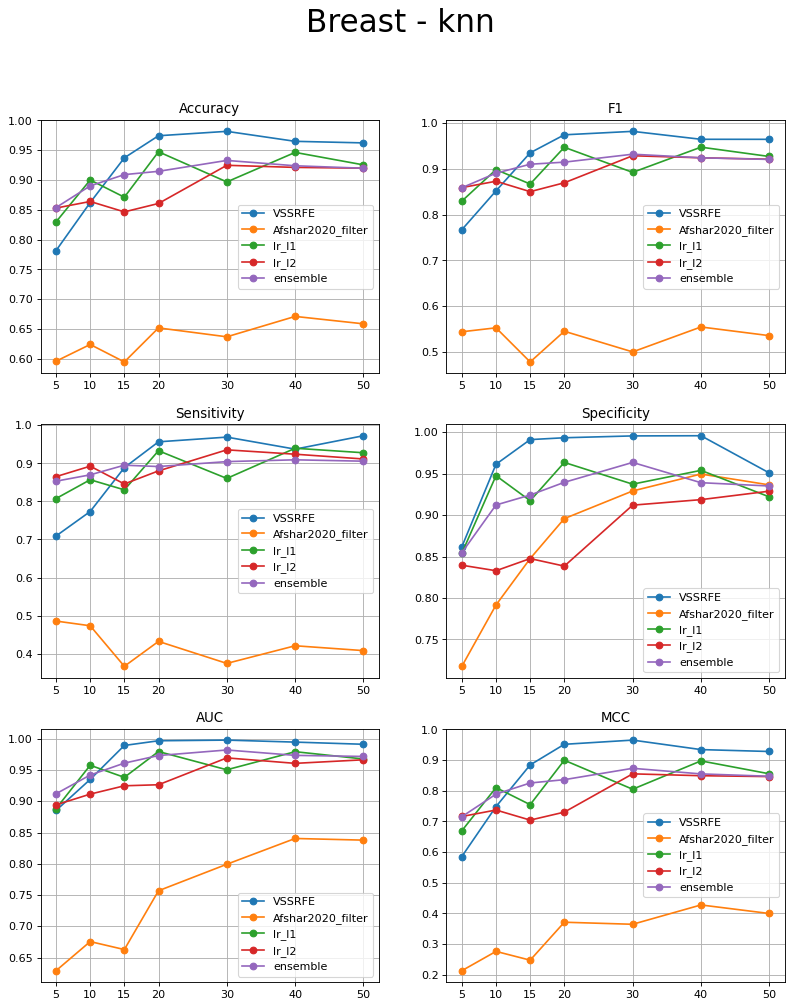

In [27]:
plot_results(datasets[1][0], 'knn', results_breast_knn4_10)

In [28]:
svc07 = svm.SVC(kernel='linear',C=0.7,probability=True)
results_ovarian_svc07_10 = test_dataset(datasets[2], 10, svc07)

processing  Ovarian
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end r

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 50


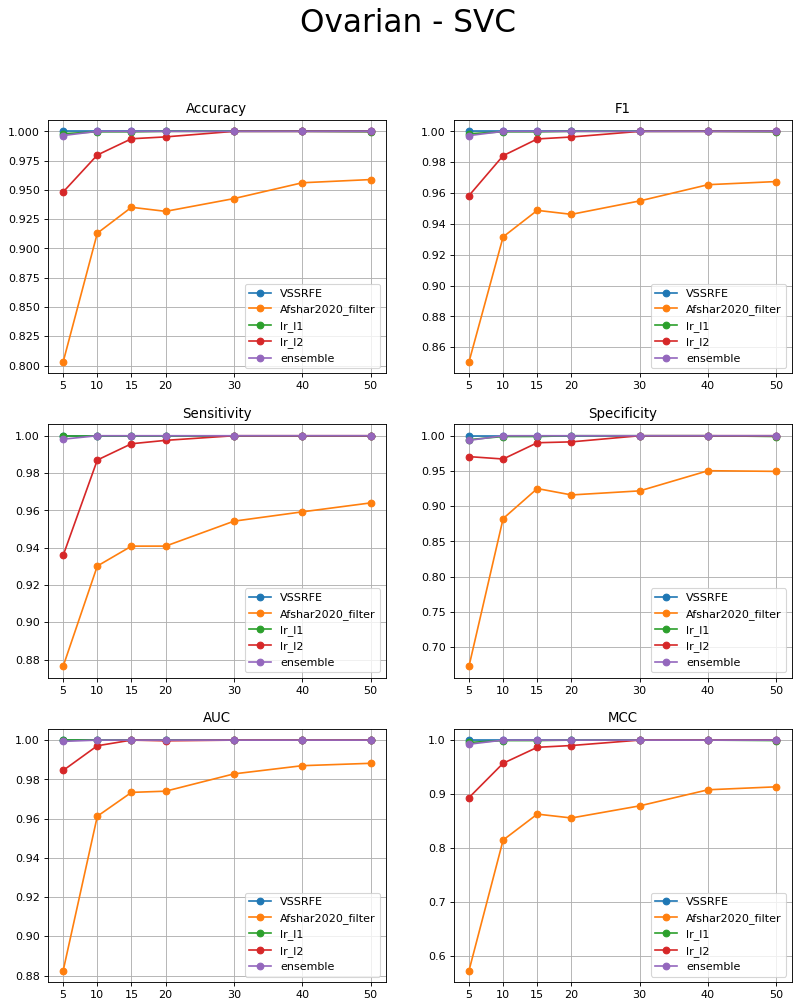

In [29]:
plot_results(datasets[2][0], 'SVC', results_ovarian_svc07_10)

In [31]:
knn4 = KNeighborsClassifier(n_neighbors=4)
results_ovarian_knn_10 = test_dataset(datasets[2], 10, knn4)

processing  Ovarian
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end r

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 50


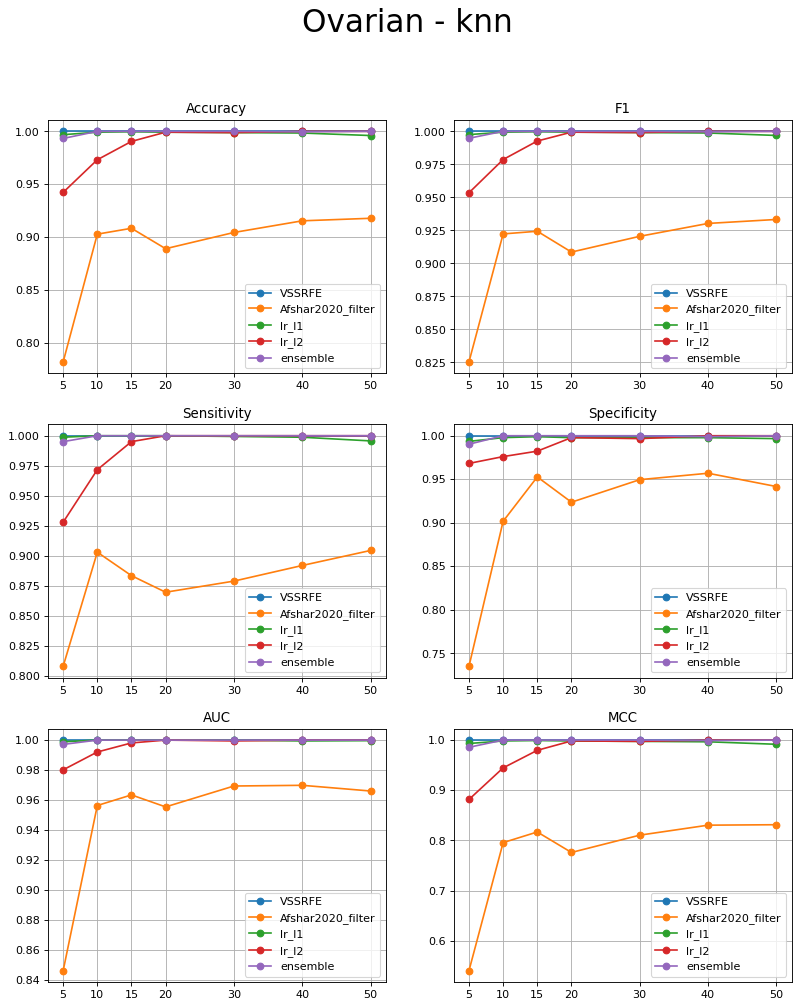

In [32]:
plot_results(datasets[2][0], 'knn', results_ovarian_knn_10)

In [33]:
svc07 = svm.SVC(kernel='linear',C=0.7,probability=True)
results_leukemia_svc07_10 = test_dataset(datasets[3], 10, svc07)

processing  Leukemia
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end 

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


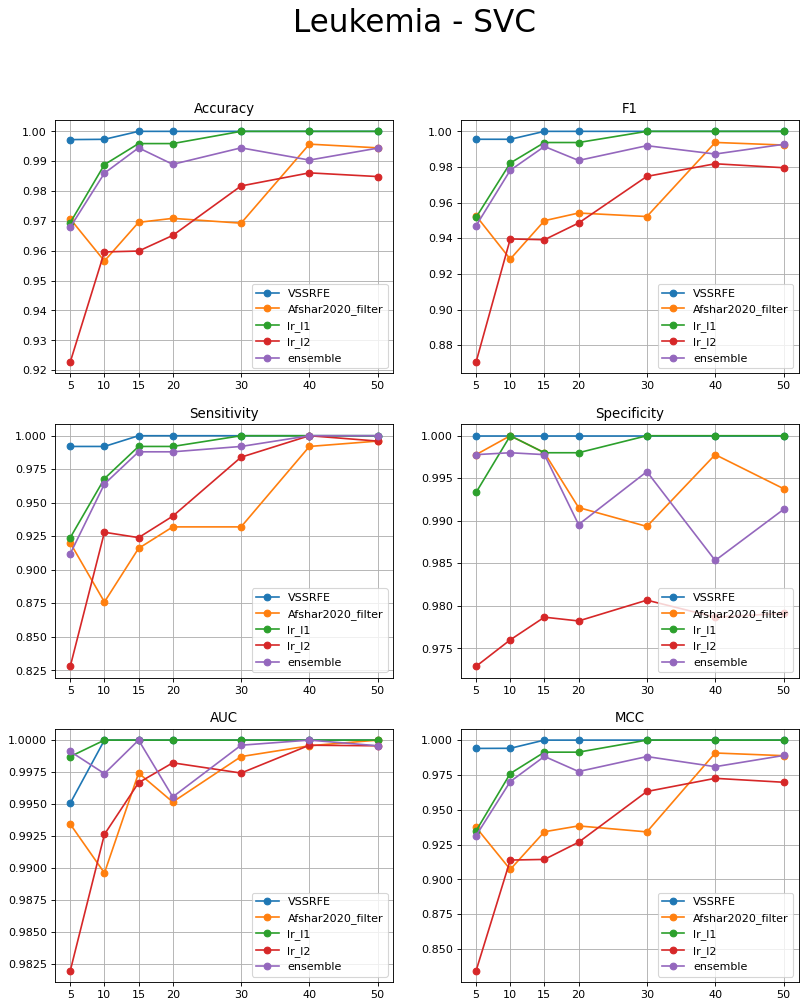

In [34]:
plot_results(datasets[3][0], 'SVC', results_leukemia_svc07_10)

In [35]:
knn4 = KNeighborsClassifier(n_neighbors=4)
results_leukemia_knn_10 = test_dataset(datasets[3], 10, knn4)

processing  Leukemia
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end 

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


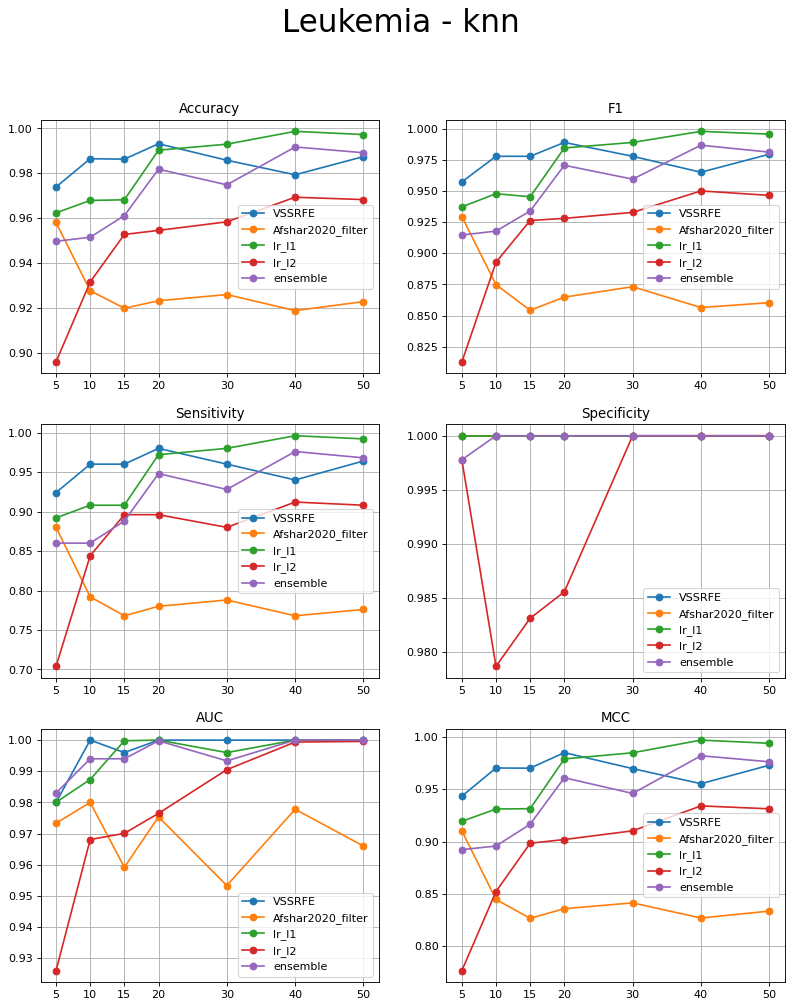

In [36]:
plot_results(datasets[3][0], 'knn', results_leukemia_knn_10)

In [45]:
svc07 = svm.SVC(kernel='linear',C=0.7,probability=True)
results_prostate_svc07_10 = test_dataset(datasets[4], 10, svc07)

processing  Prostate
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end 

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


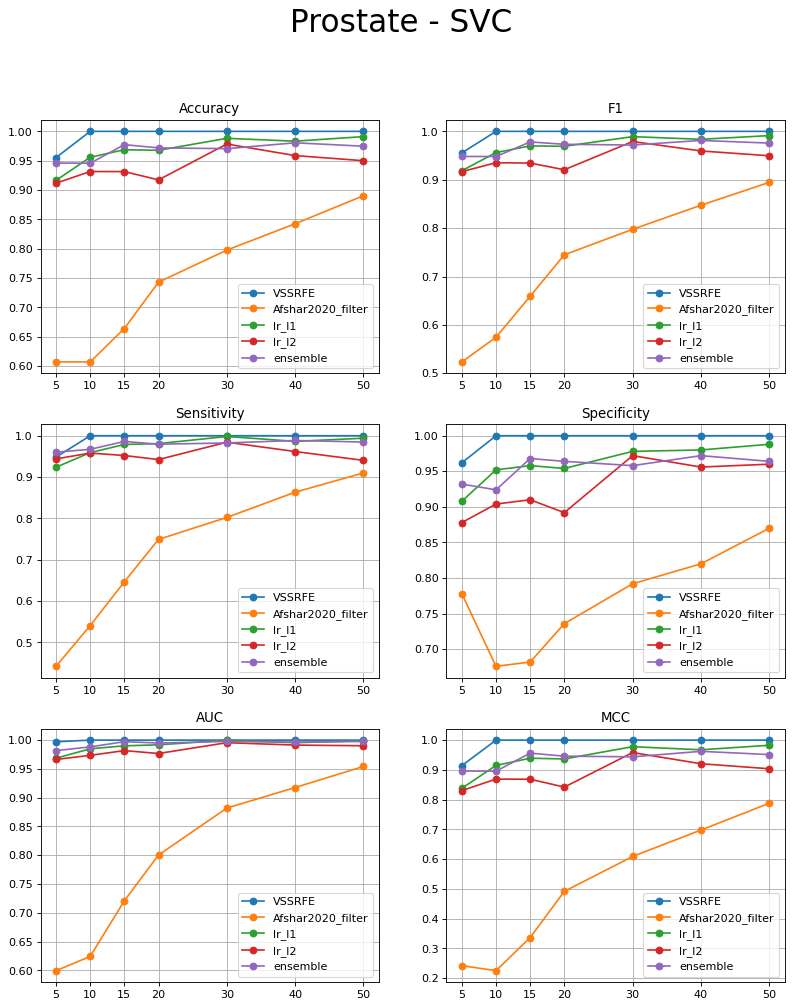

In [46]:
plot_results(datasets[4][0], 'SVC', results_prostate_svc07_10)

In [47]:
knn4 = KNeighborsClassifier(n_neighbors=4)
results_prostate_knn_10 = test_dataset(datasets[4], 10, knn4)

processing  Prostate
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4
end 

/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
Afshar2020_filter end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 50
start lr_l1
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 15
end run 0
e

konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


In [70]:
results_prostate_knn_10

{'VSSRFE': [(5,
   0.9635238095238096,
   0.9848545454545453,
   0.9299917726979124,
   0.9438181818181818,
   0.984,
   0.9624822662717399,
   0.7136087656021118),
  (10,
   0.9853809523809524,
   0.9979818181818183,
   0.9717097577563367,
   0.984909090909091,
   0.9860000000000001,
   0.9856695097427363,
   0.7055104017257691),
  (15,
   0.9970000000000001,
   0.9999,
   0.9942720420239974,
   0.998,
   0.9960000000000001,
   0.9970426065162907,
   0.7148079872131348),
  (20,
   0.999,
   1.0,
   0.9980906806746658,
   1.0,
   0.998,
   0.9990476190476191,
   0.716211485862732),
  (30,
   0.9980476190476191,
   1.0,
   0.9962724988564841,
   0.9961818181818183,
   1.0,
   0.9979949874686718,
   0.6871365308761597),
  (40,
   0.999,
   0.9999,
   0.9980906806746658,
   1.0,
   0.998,
   0.9990476190476191,
   0.6948042392730713),
  (50,
   0.9951428571428572,
   0.9995363636363637,
   0.9905449977129679,
   0.9963636363636365,
   0.994,
   0.9953246753246754,
   0.697846531867981)],


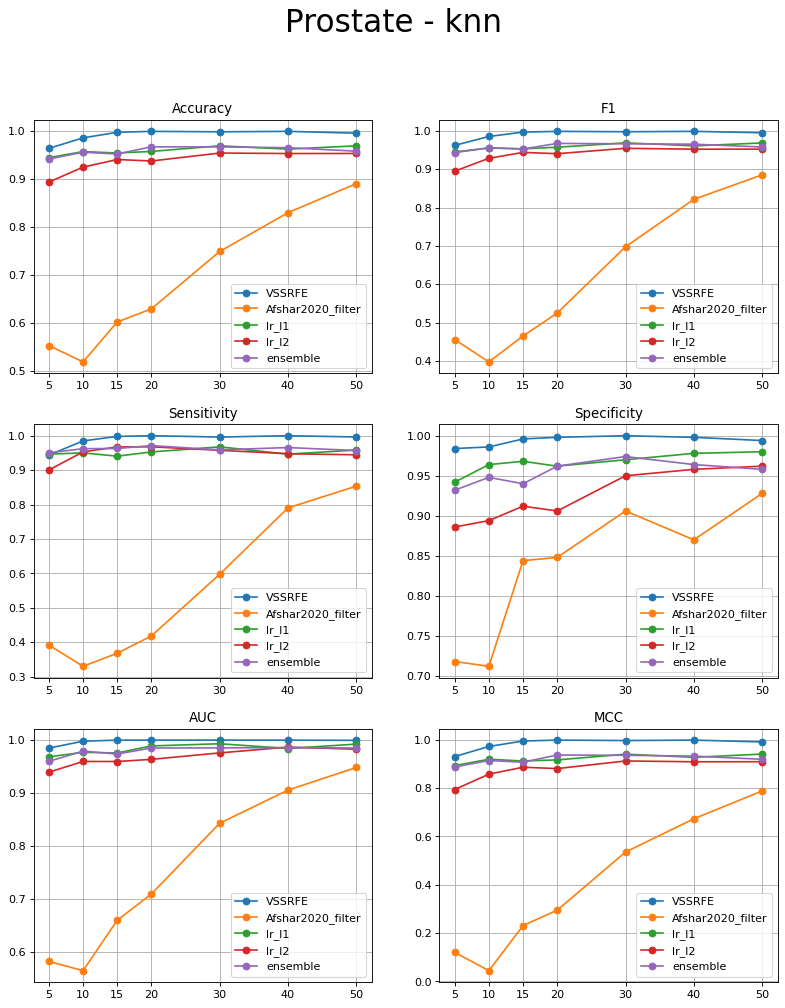

In [69]:
plot_results(datasets[4][0], 'knn', results_prostate_knn_10) #wrong title

In [38]:
svc07 = svm.SVC(kernel='linear',C=0.7,probability=True)
results_colon_svc07_10 = test_dataset(datasets[5], 10, svc07)

processing  Colon
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1
end run 2
end run 3
end run 4


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 50
start lr_l1
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end

/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0
end run 1
end run 2


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 5


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 50
start ensemble


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


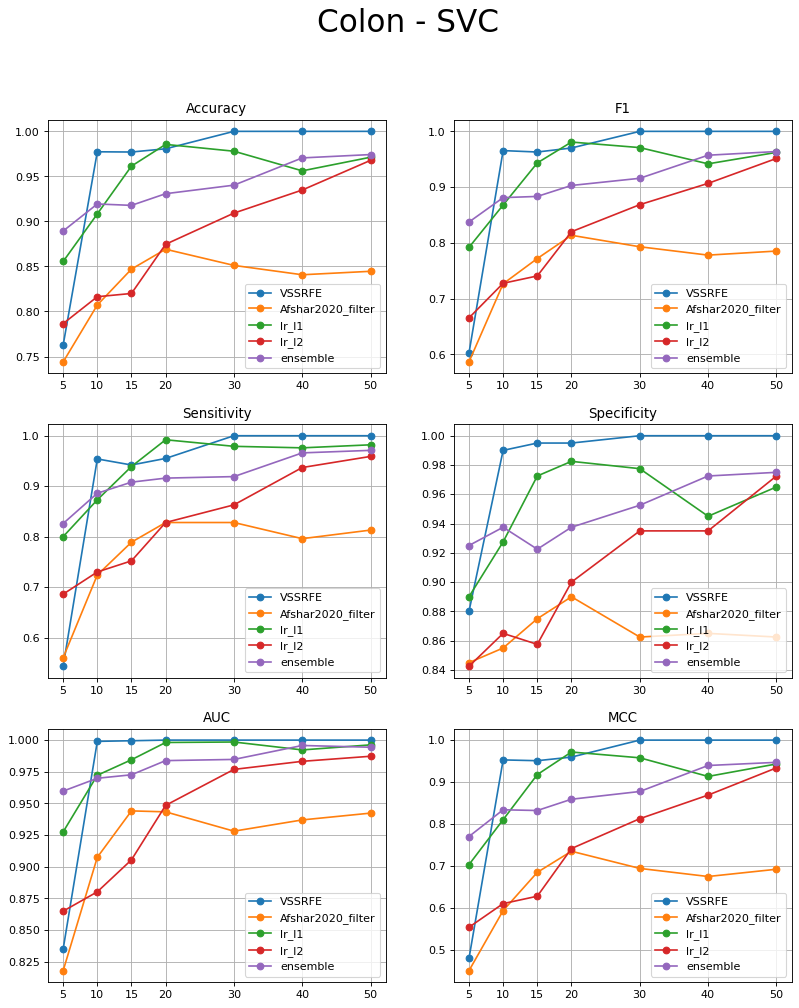

In [39]:
plot_results(datasets[5][0], 'SVC', results_colon_svc07_10)

In [40]:
knn4 = KNeighborsClassifier(n_neighbors=4)
results_colon_knn_10 = test_dataset(datasets[5], 10, knn4)

processing  Colon
start VSSRFE
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 7
end run 8
end run 9
VSSRFE end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
VSSRFE end n_features = 50
start Afshar2020_filter
end run 0
end run 1


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 2
end run 3
end run 4
end run 5


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 6
end run 7
end run 8


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
Afshar2020_filter end n_features = 5
end run 0
end run 1
end run 2
end run 3


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 4


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 5
end run 6
end run 7


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 8
end run 9
Afshar2020_filter end n_features = 10


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 15


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 1
end run 2
end run 3
end run 4
end run 5


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 6
end run 7
end run 8
end run 9
Afshar2020_filter end n_features = 20
end run 0
end run 1


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 2
end run 3
end run 4
end run 5
end run 6


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 7
end run 8


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
Afshar2020_filter end n_features = 30


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
Afshar2020_filter end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 7
end run 8


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
Afshar2020_filter end n_features = 50
start lr_l1
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 10
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l1 end n_features = 50
start lr_l2
end run 0


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 1


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 2
end run 3
end run 4
end run 5
end run 6


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 7
end run 8
end run 9
lr_l2 end n_features = 5
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 10
end run 0
end run 1
end run 2


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 3
end run 4


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 5
end run 6


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 7


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 8


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 9
lr_l2 end n_features = 15
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6


/usr/local/anaconda3/envs/mgr-exp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


end run 7
end run 8
end run 9
lr_l2 end n_features = 20
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 30
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 40
end run 0
end run 1
end run 2
end run 3
end run 4
end run 5
end run 6
end run 7
end run 8
end run 9
lr_l2 end n_features = 50
start ensemble


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 10


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 15


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 20


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 30


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 9
ensemble end n_features = 40


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 0


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 1


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 2


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 3


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 4


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 5


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 6


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 7


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


end run 8
end run 9
ensemble end n_features = 50


konsensus/model/model.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([_get_proper_attribute(component) for component in self.components.values()])


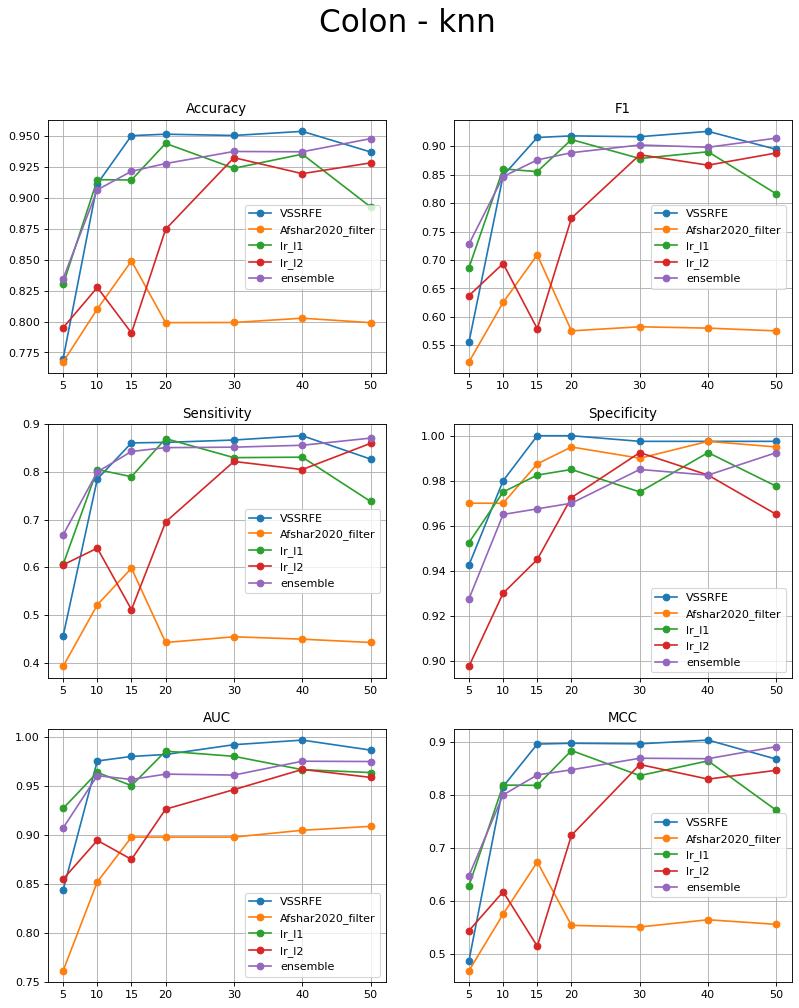

In [41]:
plot_results(datasets[5][0], 'knn', results_colon_knn_10)

In [87]:
results_all = [
results_cns_svc07_10,
results_cns_knn4_10,
results_breast_svc07_10,
results_breast_knn4_10,
results_ovarian_svc07_10,
results_ovarian_knn_10,
results_leukemia_svc07_10,
results_leukemia_knn_10,
results_prostate_svc07_10,
results_prostate_knn_10,
results_colon_svc07_10,
results_colon_knn_10
]
def mean_ds(results):
    ret = {}
    for alg, res in results.items():
        ret[alg] = np.mean([np.mean(ds[1:-1]) for ds in res])
    return ret
        
mean_ds(results_cns_svc07_10)

{'VSSRFE': 0.9584535059617024,
 'Afshar2020_filter': 0.8112242138431017,
 'lr_l1': 0.9156784277251562,
 'lr_l2': 0.8143681171771824,
 'ensemble': 0.915556131713218}

In [90]:
agg = {}
for res in results_all:
    mean = mean_ds(res)
    for alg, val in mean.items():
        agg[alg] = agg.get(alg, 0) + val
for alg, val in agg.items():
    agg[alg] = val / len(results_all)

In [91]:
agg

{'VSSRFE': 0.9626172344813728,
 'Afshar2020_filter': 0.7809422041445674,
 'lr_l1': 0.9421159317157537,
 'lr_l2': 0.8911700688489028,
 'ensemble': 0.9391675692727516}